# Machine Learning Pong

In [ ]:
import pandas as pd

df = pd.read_csv('./data/game_log.csv')

## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

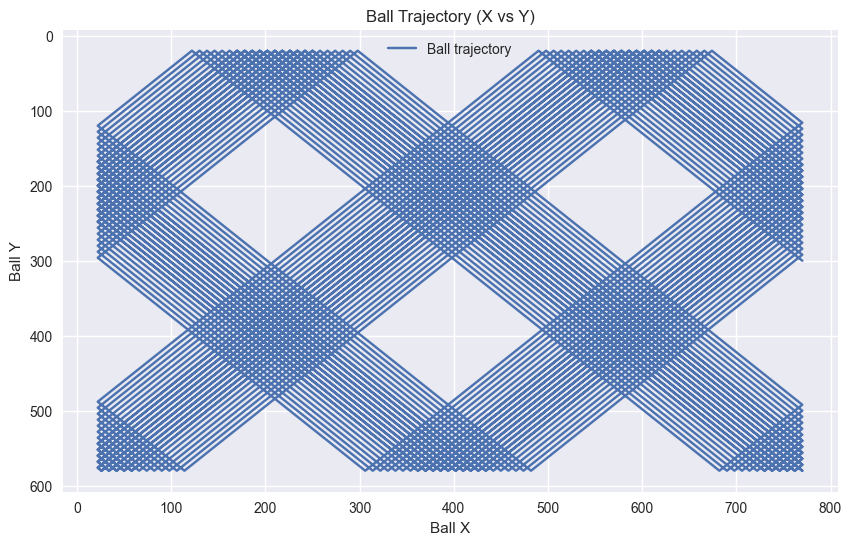

In [16]:
# Plot ball trajectory
plt.figure(figsize=(10, 6))
plt.plot(df['ball_x'], df['ball_y'], label='Ball trajectory')
plt.xlabel('Ball X')
plt.ylabel('Ball Y')
plt.title('Ball Trajectory (X vs Y)')
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Invert Y to match game screen coordinates
plt.show()

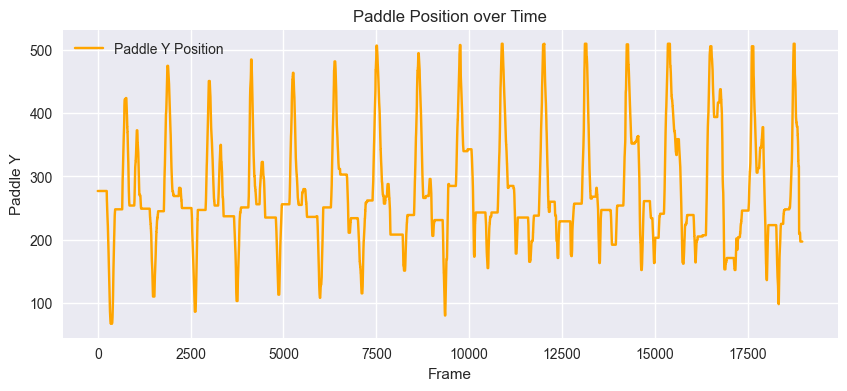

In [18]:
# Plot paddle position over time
plt.figure(figsize=(10, 4))
plt.plot(df['paddle_y'], label='Paddle Y Position', color='orange')
plt.title('Paddle Position over Time')
plt.xlabel('Frame')
plt.ylabel('Paddle Y')
plt.grid(True)
plt.legend()
plt.show()

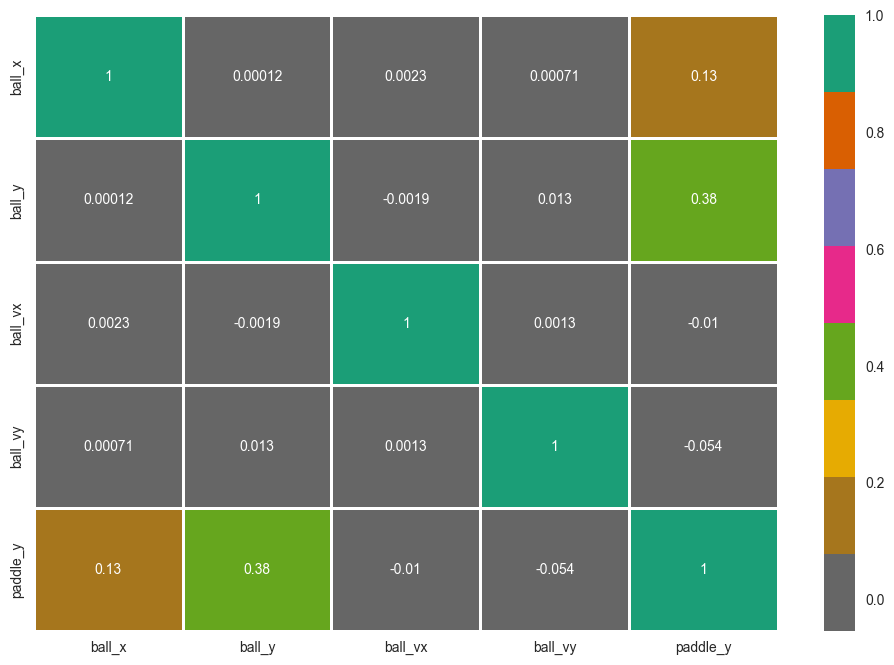

In [20]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(), annot=True, cmap='Dark2_r', linewidths = 2)
plt.show()

In [22]:
def plot_random_scatter(dataframe, x_col, y_col, sample_size=180):
    sample_df = dataframe.sample(n=sample_size, random_state=42)
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sample_df, x=x_col, y=y_col, color='blue', edgecolor='w', s=60)
    plt.title('Scatter Plot of Random Sample')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()

## Data Preprocessing

In [77]:
df.head()

,ball_x,ball_y,ball_vx,ball_vy,paddle_y
0,770,300,-4,-4,277
1,766,296,-4,-4,277
2,762,292,-4,-4,277
3,758,288,-4,-4,277
4,754,284,-4,-4,277


In [78]:
df.shape

(18968, 5)

In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ball_x,18968.0,396.492408,216.709626,22.0,210.0,398.0,586.0,770.0
ball_y,18968.0,299.050822,161.606442,20.0,160.0,296.0,440.0,580.0
ball_vx,18968.0,-0.043863,3.999865,-4.0,-4.0,-4.0,4.0,4.0
ball_vy,18968.0,0.005061,4.000102,-4.0,-4.0,4.0,4.0,4.0
paddle_y,18968.0,272.238138,84.313023,67.0,231.0,250.0,303.0,510.0


In [80]:
df.dropna(inplace=True)

In [81]:
X = df[['ball_x', 'ball_y', 'ball_vx', 'ball_vy']].values  # Features
y = df['paddle_y']  # Target

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model training and evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [95]:
# Store results
results = {}

In [96]:
# 1. Linear Regression (no hyperparameters to tune, but included for completeness)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'R2': r2_score(y_test, y_pred_lr)
}

In [97]:
# 2. Polynomial Regression + Linear Regression
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lr', LinearRegression())
])
poly_params = {
    'poly__degree': [12, 16, 20]
}
grid_poly = GridSearchCV(poly_pipeline, poly_params, cv=5, verbose=3, n_jobs=-1)
grid_poly.fit(X_train, y_train)
y_pred_poly = grid_poly.predict(X_test)
results[f'Polynomial Regression (deg={grid_poly.best_params_["poly__degree"]})'] = {
    'MSE': mean_squared_error(y_test, y_pred_poly),
    'R2': r2_score(y_test, y_pred_poly)
}

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [98]:
# 3. KNN Regression
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(knn_pipeline, knn_params, cv=5, verbose=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)
y_pred_knn = grid_knn.predict(X_test)
results[f'KNN Regression (best={grid_knn.best_params_})'] = {
    'MSE': mean_squared_error(y_test, y_pred_knn),
    'R2': r2_score(y_test, y_pred_knn)
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [99]:
# 4. Random Forest Regression
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])
rf_params = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30]
}
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, verbose=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
results[f'Random Forest Regression (best={grid_rf.best_params_})'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [100]:
# Display results
print("Model Evaluation Results:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R2']:.2f}")

Model Evaluation Results:
Linear Regression: MSE = 5896.97, R² = 0.16
Polynomial Regression (deg=16): MSE = 525.60, R² = 0.93
KNN Regression (best={'knn__n_neighbors': 3, 'knn__weights': 'distance'}): MSE = 285.67, R² = 0.96
Random Forest Regression (best={'rf__max_depth': 20, 'rf__n_estimators': 200}): MSE = 598.00, R² = 0.92


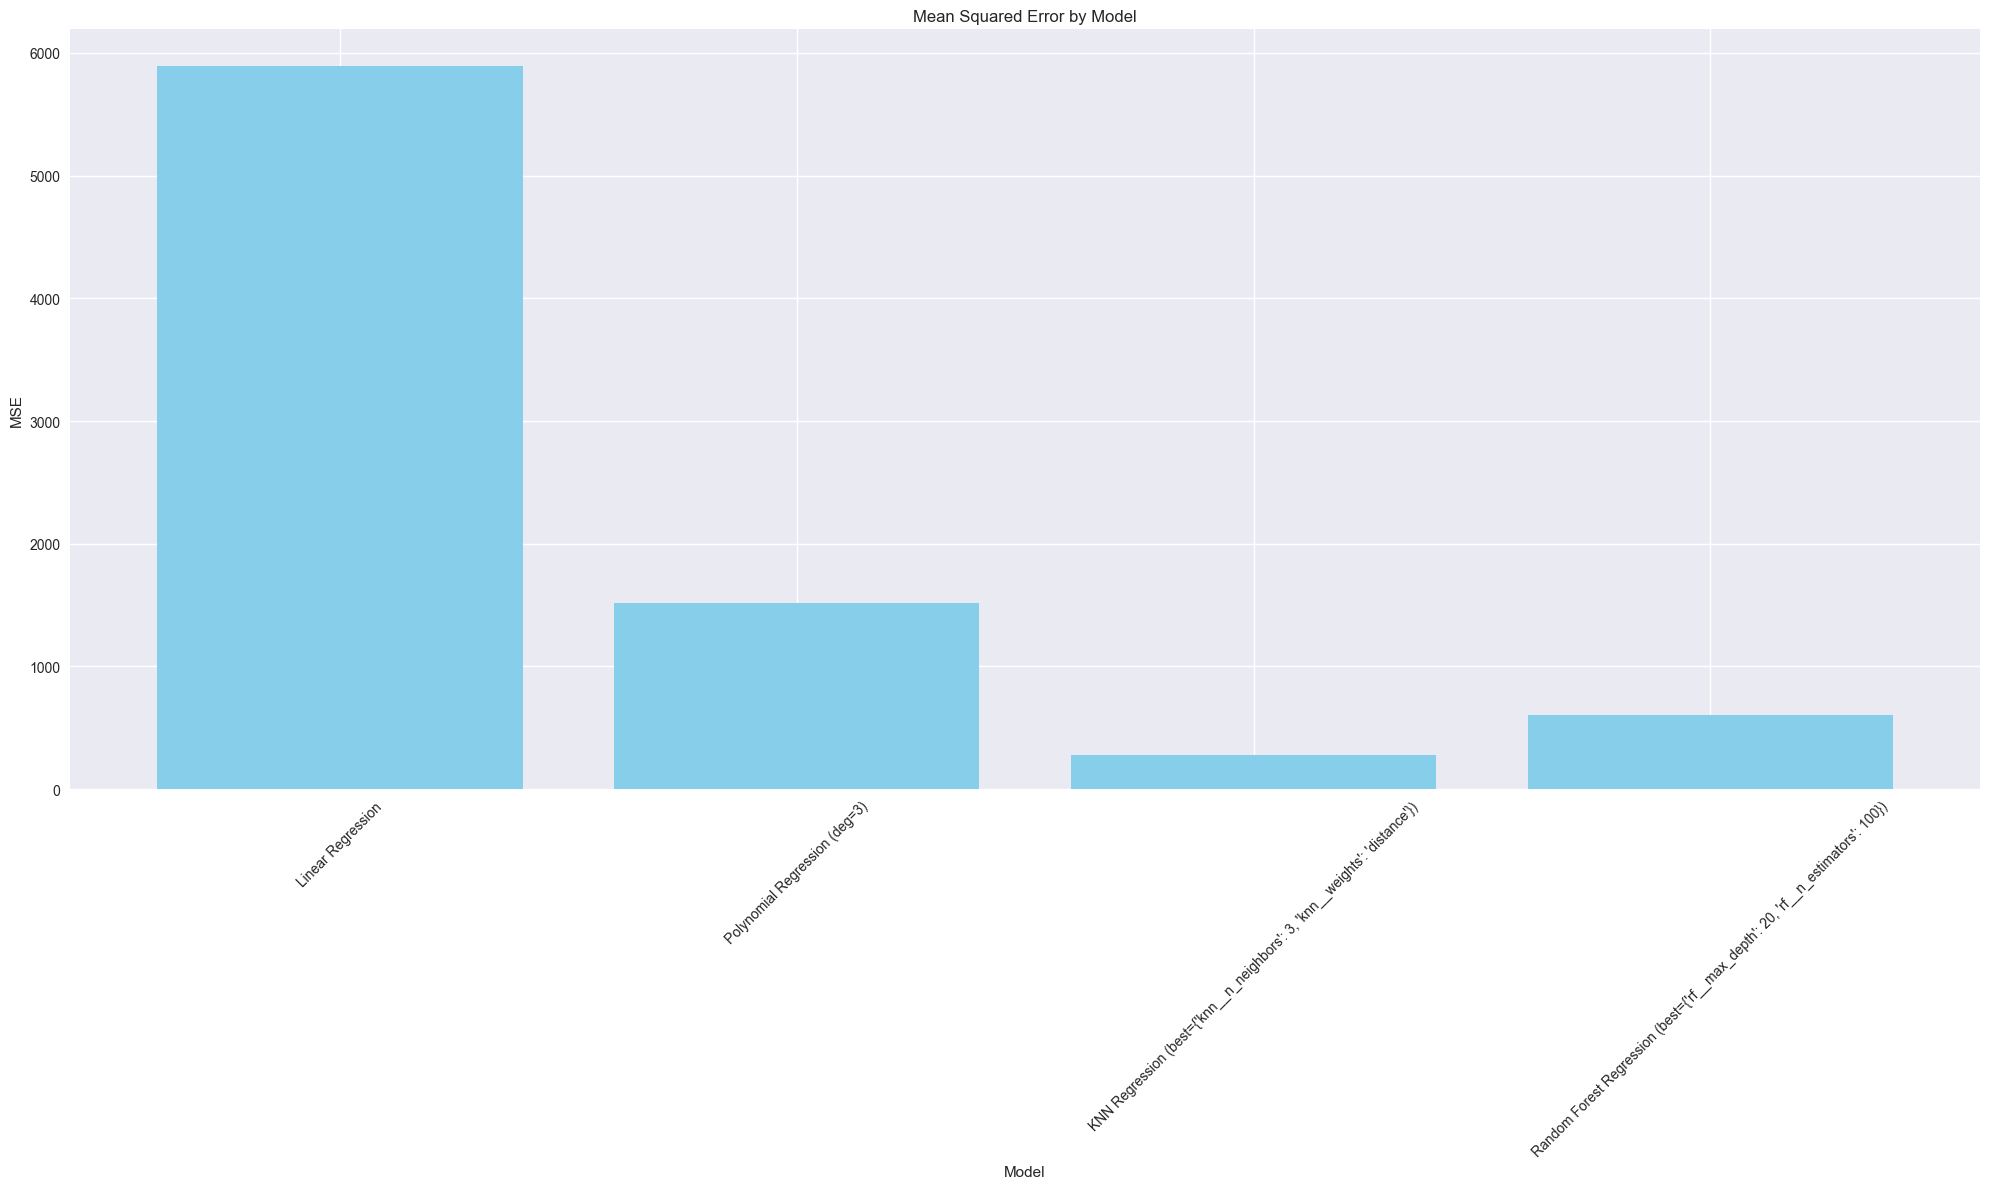

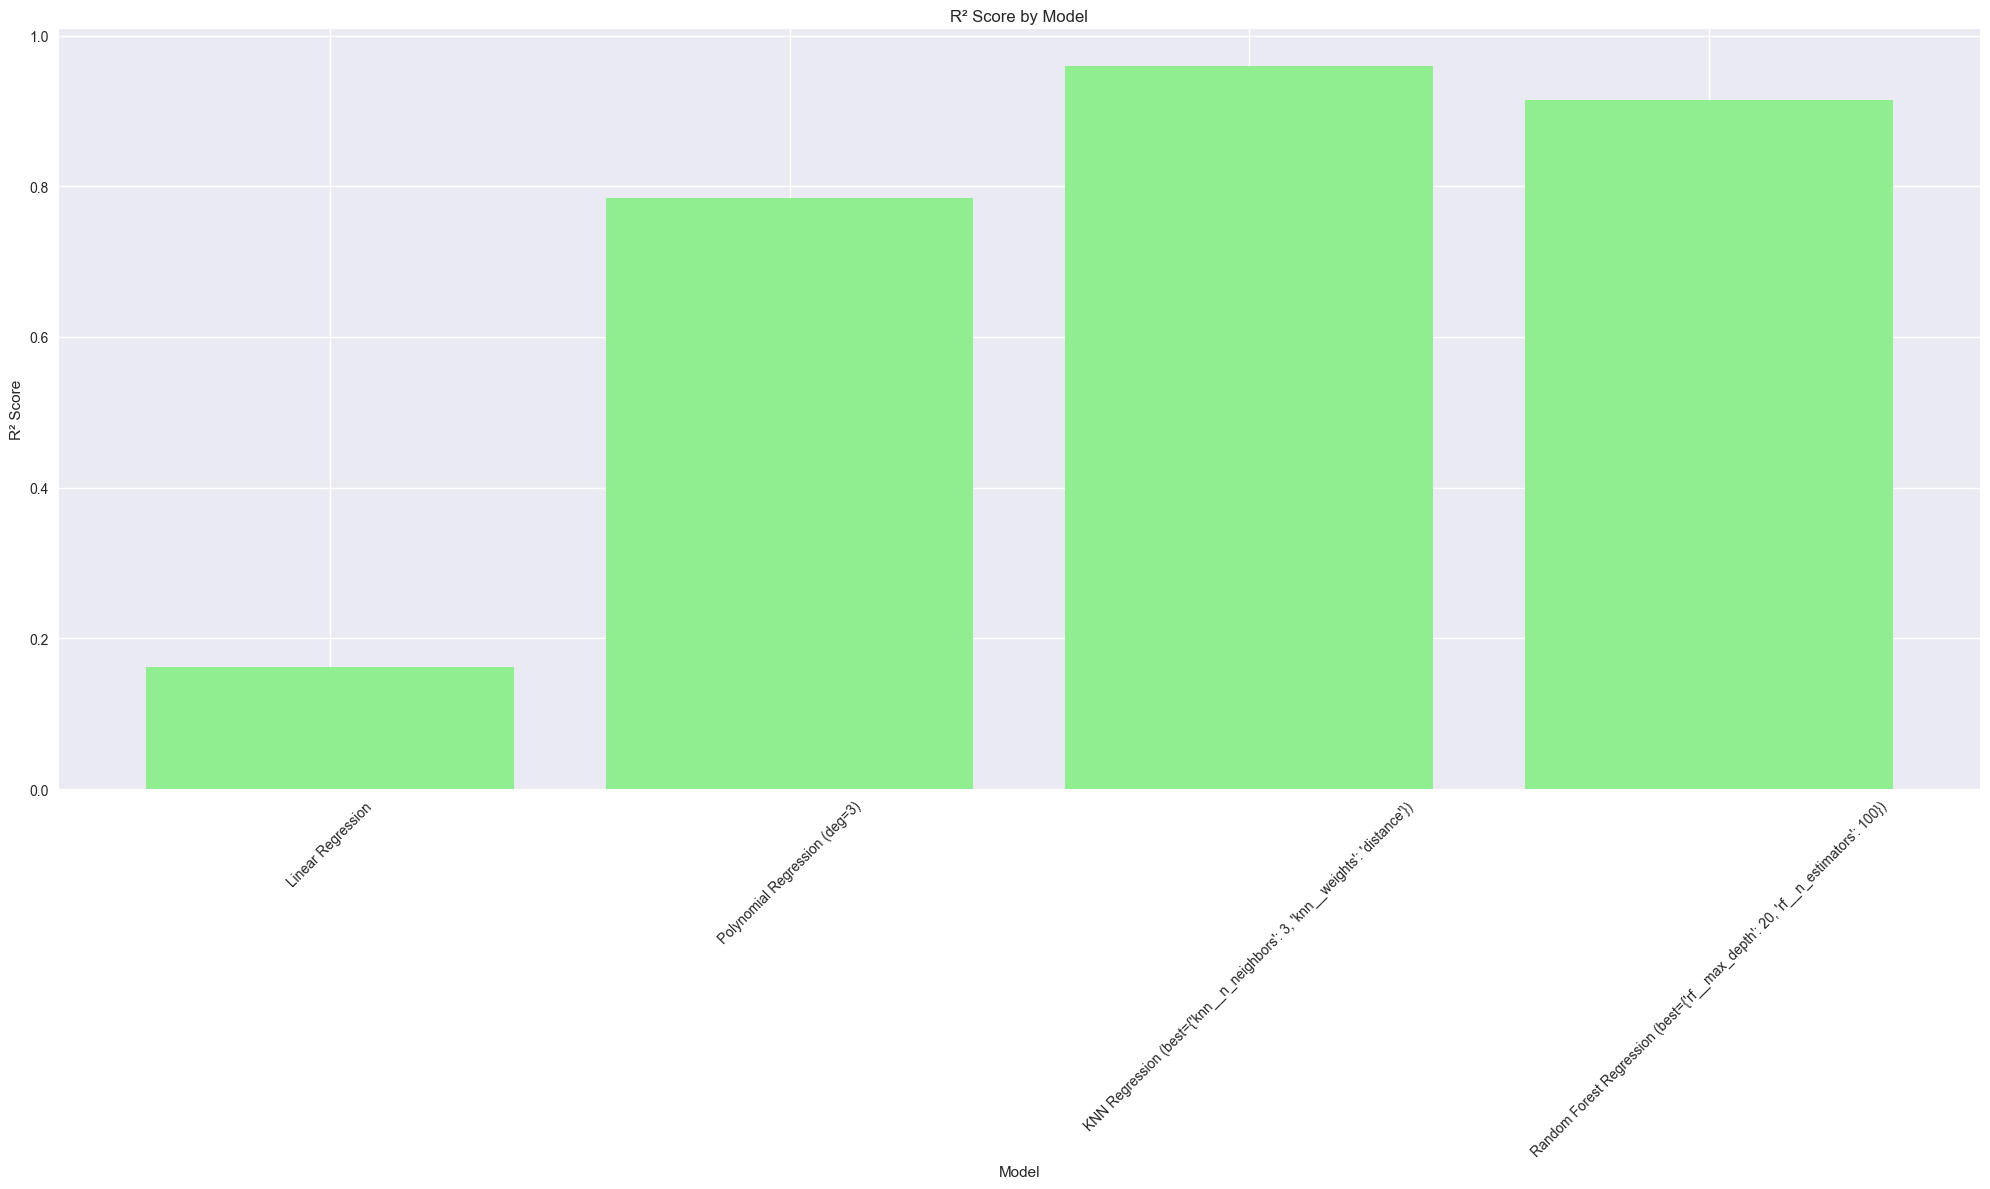

In [75]:
models = list(results.keys())
mse_scores = [results[model]['MSE'] for model in models]
r2_scores = [results[model]['R2'] for model in models]

plt.style.use('seaborn-v0_8')

# Plot MSE
plt.figure(figsize=(20, 12))
plt.bar(models, mse_scores, color='skyblue')
plt.title('Mean Squared Error by Model')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot R2
plt.figure(figsize=(20, 12))
plt.bar(models, r2_scores, color='lightgreen')
plt.title('R² Score by Model')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()

# 

# Save Model

In [104]:
# Retraining Polynomial Regression on full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the model
final_model = KNeighborsRegressor(n_neighbors=grid_knn.best_params_['knn__n_neighbors'], weights=grid_knn.best_params_['knn__weights'])
final_model.fit(X_scaled, y)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [105]:
import joblib


joblib.dump(final_model, './model/ml_model.pkl')
joblib.dump(scaler, './model/scaler.pkl')

['./model/scaler.pkl']

In [106]:
model = joblib.load('./model/ml_model.pkl')

In [107]:
print(model.__class__.__name__)

KNeighborsRegressor
